<a href="https://colab.research.google.com/github/hardzal/final-assigment-college/blob/master/main_apps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hybrid Recommendation System using BERT
### Muhammad Rizal (123170036) - Informatika
##### UPN 'Veteran' Yogkyakarta

In [1]:
!pip install scikit-surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 KB 19.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp38-cp38-linux_x86_64.whl size=3366507 sha256=47959d6d7cbcaa538565bb8e8dba08ba66ef13bf70f4c02001e3df73a423a17d
  Stored in directory: /root/.cache/pip/wheels/af/db/86/2c18183a80ba05da35bf0fb7417aac5cddbd93bcb1b92fd3ea
Successfully built scikit-surprise


### Load data and install module

In [2]:
import pandas as pd
import numpy as np

import random
from random import random

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from scipy.sparse import csc_matrix
from scipy.sparse.linalg import svds

from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
from surprise.model_selection import cross_validate

from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline

from surprise.prediction_algorithms import KNNBaseline
from surprise.prediction_algorithms import SVD

from surprise.similarities import cosine, msd, pearson

from surprise import accuracy

from surprise import Reader
from surprise import Dataset

import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk import word_tokenize, FreqDist
import string
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
anime_df = pd.read_csv('./anime.csv')
anime_df.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [4]:
anime_df.describe()

,anime_id,rating,members
count,12294.000000,12064.000000,1.229400e+04
mean,14058.221653,6.473902,1.807134e+04
std,11455.294701,1.026746,5.482068e+04
min,1.000000,1.670000,5.000000e+00
25%,3484.250000,5.880000,2.250000e+02
50%,10260.500000,6.570000,1.550000e+03
75%,24794.500000,7.180000,9.437000e+03
max,34527.000000,10.000000,1.013917e+06


In [5]:
rating_df = pd.read_csv('./rating.csv')
rating_df.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [6]:
anime_df.shape

(12294, 7)

In [7]:
anime_df.nunique() # number of unique values in each column

anime_id    12294
name        12292
genre        3264
type            6
episodes      187
rating        598
members      6706
dtype: int64

In [8]:
anime_df.isnull().sum()

anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64

### Data Preprocessing

In [9]:
anime_df.dropna(inplace=True)
anime_df.shape

(12017, 7)

In [10]:
anime_df.shape[0]

12017

In [11]:
anime_df.genre.fillna("NULL",inplace=True)
anime_df.type.fillna("NULL",inplace=True)
anime_df.rating.fillna(anime_df.rating.mean(),inplace=True)
anime_df.isnull()

,anime_id,name,genre,type,episodes,rating,members
0,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...
12289,False,False,False,False,False,False,False
12290,False,False,False,False,False,False,False
12291,False,False,False,False,False,False,False
12292,False,False,False,False,False,False,False


In [12]:
anime_df.isnull().sum()

anime_id    0
name        0
genre       0
type        0
episodes    0
rating      0
members     0
dtype: int64

In [13]:
rating_df.shape

(7651647, 3)

In [14]:
rating_df.dropna(inplace=True)
rating_df.shape

(7651647, 3)

In [15]:
rating_df.rating.replace({-1: np.nan}, regex=True, inplace = True)
rating_df.head()

,user_id,anime_id,rating
0,1,20,NaN
1,1,24,NaN
2,1,79,NaN
3,1,226,NaN
4,1,241,NaN


In [16]:
badAnimes = [x  for x in rating_df.anime_id.unique() if x not in anime_df.anime_id.unique() ] 
badAnimes

[28647,
 28653,
 28655,
 28987,
 33242,
 19219,
 28587,
 29765,
 30309,
 31834,
 29629,
 29655,
 29920,
 29921,
 29922,
 29923,
 29957,
 30399,
 30408,
 30435,
 31506,
 31507,
 31760,
 31831,
 31832,
 31833,
 32636,
 32695,
 30913,
 33187,
 30924,
 30484,
 30862,
 33674,
 9488,
 20261,
 31510,
 31511]

In [47]:
badIndecies = rating_df[rating_df.anime_id.isin(badAnimes)].index
badIndecies

Int64Index([ 111900,  111901,  111902,  111924,  203759,  443617,  443679,
             443691,  496247,  577131,
            ...
            6977518, 7278562, 7457644, 7520598, 7581492, 7581501, 7581525,
            7581526, 7581527, 7581528],
           dtype='int64', length=125)

In [49]:
rating_df.drop(badIndecies,inplace=True)

In [52]:
rating_df.rating.eq(-1).sum() 

0

In [50]:
rating_df.shape

(7651522, 3)

In [53]:
ratingsMean = anime_df.rating.mean()
membersMean = anime_df.members.mean()

In [54]:
ratingsMean

6.478264125821752

In [55]:
membersMean

18348.87900474328

In [57]:
base = anime_df.copy() 

base.drop(["episodes","name"],axis=1,inplace=True) 

In [60]:
anime_df.shape

(12017, 7)

In [58]:
base.shape

(12017, 5)

In [17]:
anime_df.dtypes

anime_id      int64
name         object
genre        object
type         object
episodes     object
rating      float64
members       int64
dtype: object

In [18]:
df_merge = pd.merge(anime_df, rating_df, on='anime_id')
df_merge.head()

,anime_id,name,genre,type,episodes,rating_x,members,user_id,rating_y
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,99,5.0
1,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,152,10.0
2,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,244,10.0
3,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,271,10.0
4,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,278,NaN


In [19]:
df_merge.shape

(7651522, 9)

In [20]:
df_merge.rating_x.min()

1.67

In [21]:
df_merge.rating_y.min()

1.0

In [22]:
## Menghapus data rating yang negatif
df_merge = df_merge[df_merge.rating_y != -1]
df_merge.head()

,anime_id,name,genre,type,episodes,rating_x,members,user_id,rating_y
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,99,5.0
1,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,152,10.0
2,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,244,10.0
3,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,271,10.0
4,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,278,NaN


In [23]:
df_merge.shape

(7651522, 9)

In [24]:
df_merge.dtypes

anime_id      int64
name         object
genre        object
type         object
episodes     object
rating_x    float64
members       int64
user_id       int64
rating_y    float64
dtype: object

In [25]:
df_merge['rating_x'] = df_merge['rating_x'].astype(int)

In [26]:
df_merge.dtypes

anime_id      int64
name         object
genre        object
type         object
episodes     object
rating_x      int64
members       int64
user_id       int64
rating_y    float64
dtype: object

In [27]:
ratings_x = df_merge['rating_x'].value_counts()
ratings_y = df_merge['rating_y'].value_counts()

In [28]:
ratings_x

7    4135981
8    2294794
6    1029755
5      88901
9      87537
4       8684
3       4055
2       1812
1          3
Name: rating_x, dtype: int64

In [29]:
ratings_y

8.0     1611191
7.0     1347303
9.0     1226923
10.0     935720
6.0      625951
5.0      277503
4.0      102198
3.0       40578
2.0       22694
1.0       16309
Name: rating_y, dtype: int64

In [30]:
## membulatkan nilai rating
sample = df_merge
sample.rating_x = sample.rating_x.apply(round)
sample.head()

,anime_id,name,genre,type,episodes,rating_x,members,user_id,rating_y
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9,200630,99,5.0
1,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9,200630,152,10.0
2,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9,200630,244,10.0
3,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9,200630,271,10.0
4,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9,200630,278,NaN


In [31]:
sample['episodes']

0          1
1          1
2          1
3          1
4          1
          ..
7651517    1
7651518    1
7651519    1
7651520    1
7651521    1
Name: episodes, Length: 7651522, dtype: object

In [61]:
sample.dtypes

anime_id      int64
name         object
genre        object
type         object
episodes     object
rating_x      int64
members       int64
user_id       int64
rating_y    float64
dtype: object

In [66]:
sample.isnull().any()

anime_id    False
name        False
genre       False
type        False
episodes    False
rating_x    False
members     False
user_id     False
rating_y     True
dtype: bool

### Explorary Data Analysis

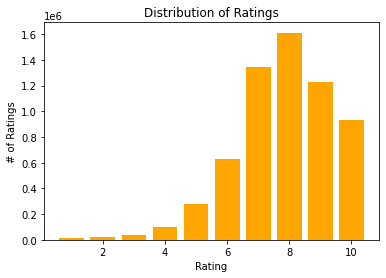

In [67]:
## EDA
# plot distribution in matplotlib
ratings_sorted = sorted(list((zip(ratings_y.index, ratings_y))))
plt.bar([r[0] for r in ratings_sorted], [r[1] for r in ratings_sorted], color='orange')
plt.xlabel("Rating")
plt.ylabel("# of Ratings")
plt.title("Distribution of Ratings")
plt.show()

In [68]:
print("Number of users:", df_merge.user_id.nunique())

Number of users: 71850


In [69]:
print("Average Number of Reviews per User: {:.2f}".format(df_merge.shape[0]/df_merge.user_id.nunique()))

Average Number of Reviews per User: 106.49


In [70]:
sample['user_id'].value_counts()

48766    10225
42635     3747
53698     2905
57620     2702
59643     2633
         ...  
17447        1
22257        1
23942        1
24759        1
64425        1
Name: user_id, Length: 71850, dtype: int64

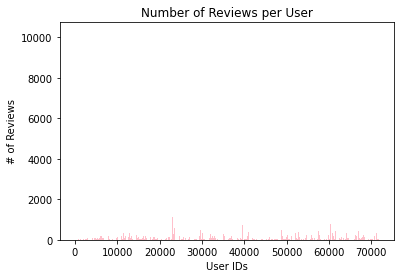

In [71]:
ratings_per_user = sample['user_id'].value_counts()
ratings_per_user = sorted(list(zip(ratings_per_user.index, ratings_per_user)))
plt.bar([r[0] for r in ratings_per_user], [r[1] for r in ratings_per_user], color='pink')
plt.xlabel('User IDs')
plt.ylabel('# of Reviews')
plt.title('Number of Reviews per User')
plt.show()

In [72]:
print("Number of users:", sample.user_id.nunique())
print("Number of types of different animee:", sample.type.nunique())
print("Type of type:", sample.type.value_counts())

Number of users: 71850
Number of types of different animee: 6
Type of type: TV         5168853
Movie      1031667
OVA         785847
Special     549092
ONA          90143
Music        25920
Name: type, dtype: int64


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


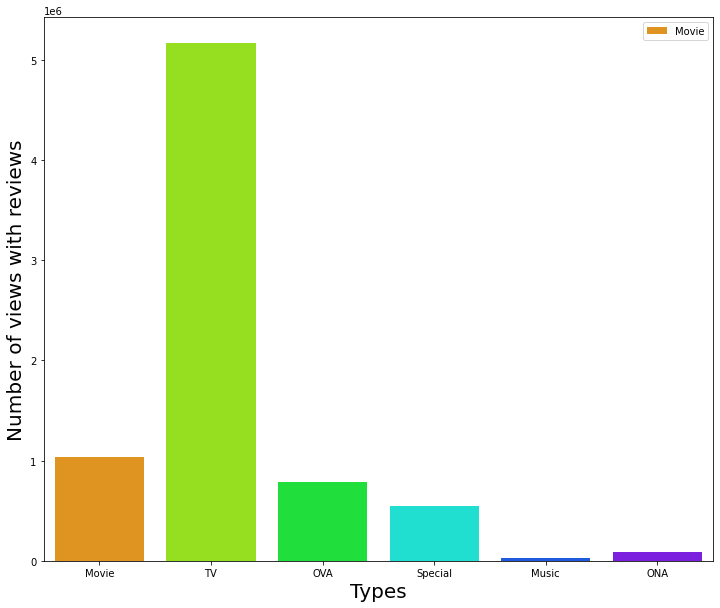

In [73]:
fig = plt.figure(figsize=(12,10))
sns.countplot(sample['type'], palette='gist_rainbow')
plt.xlabel("Types", fontsize=20)
plt.ylabel("Number of views with reviews", fontsize=20)
plt.legend(sample['type'])
plt.show()

In [74]:
def count_genre_freq(df, column, delimeter=", "):
  from collections import Counter
  non_empty_rows = df[df[column].isnull() == False][column]
  row_counted = non_empty_rows.str.split(delimeter).apply(Counter)
  total_freq = dict(sum(row_counted, Counter()))
  freq_series = pd.Series(total_freq)
  output = freq_series.sort_values(ascending=False)
  return output

In [75]:
animes_per_genre = count_genre_freq(anime_df, "genre")
animes_per_genre

Comedy           4575
Action           2768
Adventure        2316
Fantasy          2242
Sci-Fi           2036
Drama            1977
Shounen          1684
Kids             1598
Romance          1437
Slice of Life    1204
School           1176
Hentai           1133
Supernatural     1001
Mecha             929
Music             842
Historical        798
Magic             747
Ecchi             628
Shoujo            594
Sports            533
Seinen            532
Mystery           485
Super Power       451
Military          416
Parody            403
Space             377
Horror            362
Harem             313
Demons            287
Martial Arts      264
Dementia          238
Psychological     226
Police            195
Game              177
Samurai           146
Vampire           100
Thriller           86
Cars               72
Shounen Ai         62
Shoujo Ai          54
Josei              52
Yuri               41
Yaoi               38
dtype: int64

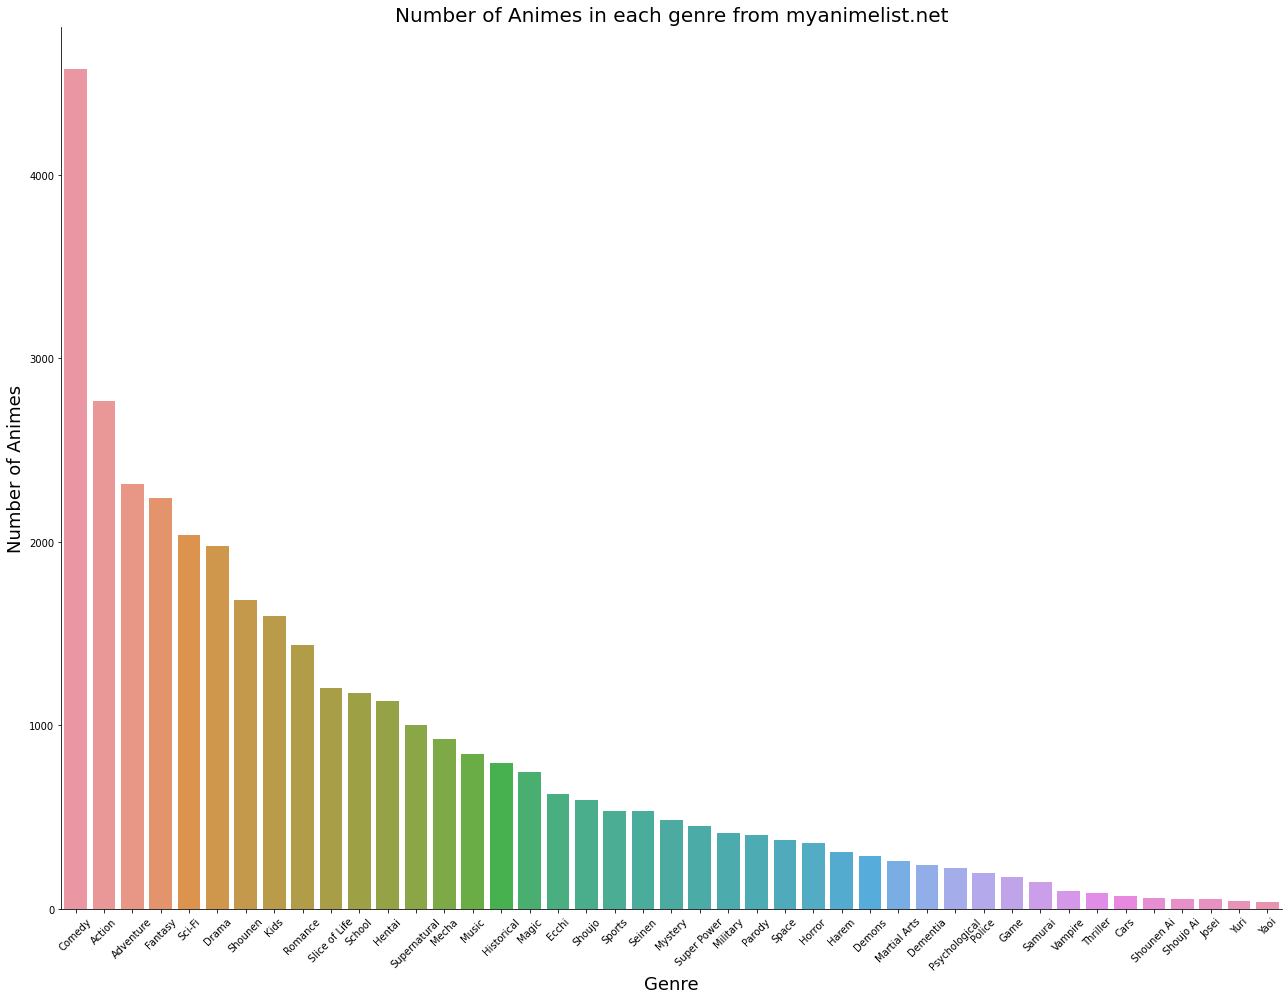

In [76]:
plt.figure(figsize=(18,14))
sns.barplot(x=animes_per_genre.index, y=animes_per_genre.values)
plt.xlabel("Genre", size=18)
plt.ylabel("Number of Animes", size=18)
plt.xticks(rotation=45)
plt.title("Number of Animes in each genre from myanimelist.net", size=20)
plt.tight_layout()
sns.despine();